In [35]:
import pandas as pd
import re
import seaborn

In [2]:
#Download the databases
page_nobel = "https://www.britannica.com/topic/Nobel-Prize-Winners-by-Year-1856946"
page_beer = "https://en.wikipedia.org/wiki/List_of_countries_by_beer_consumption_per_capita"
page_ussr = "https://en.wikipedia.org/wiki/Post-Soviet_states"

nobel_site_tables = pd.read_html(page_nobel)
beer_site_tables = pd.read_html(page_beer)
ussr_countries_tables = pd.read_html(page_ussr)

# Pre processing of data

## Handle U.S.S.R Countries

In [22]:
#Selecting the tab I need
countries_in_ussr = ussr_countries_tables[0].loc[:,'Country']
#Compiling the regex that extracts things before '(' and
#'[' in the text
before_parentesis = re.compile('([\w\s]*)[\[\(]?')
countries_in_ussr = countries_in_ussr.str.extract(before_parentesis, expand=False).iloc[:-1]

## Handle Beer data

In [49]:
beer_table = beer_site_tables[0]
#Select the columns I care of
beer_table = beer_table.iloc[:,0:3]
#Changing the name of the columns
beer_table.rename(index=str, columns={"Consumption per capita [1](litres)": "Consumption",
                                      "Global rank[1]": "Rank"}, inplace=True)
regex1 = re.compile('([\w\s]+)\[*.*')
beer_table['Country'] = beer_table['Country'].str.extract(regex1, expand=False)
#Merging ussr countries ins a unique entry with their mean
beer_table.loc[beer_table['Country'].isin(countries_in_ussr) , 'Country'] = 'U.S.S.R.'
beer_table = beer_table.groupby('Country', as_index=False).mean()
#Would like to modify these two lines
beer_table.loc[beer_table['Country']=='United Kingdom', 'Country']='U.K.'
beer_table.loc[beer_table['Country']=='United States', 'Country']='U.S.'

beer_table.head()

,Country,Rank,Consumption
0,Argentina,NaN,49.0
1,Australia,23.0,71.4
2,Austria,3.0,106.0
3,Belgium,27.0,67.4
4,Belize,11.0,85.0


## Handle Nobel data

In [50]:
##NOBEL##
nobel_table = nobel_site_tables[0]
#Select the columns and rows I care of:
nobel_table = nobel_table.loc[nobel_table.loc[:,'category'] == 'physics',:].iloc[:,1:4]
#Changing the name of a column
nobel_table.rename(index=str, columns={'country*': 'Country'}, inplace=True)
#Ingoring division in West/East Germany
nobel_table.loc[nobel_table['Country'].str.contains('Germany'), 'Country'] = 'Germany'
#Extracting the first Country form the line where there are two divided by a /
regex2 = re.compile('([\w\.]+).*')
nobel_table['Country'] = nobel_table['Country'].str.extract(regex2, expand=False)
#Merging ussr countries
nobel_table.loc[nobel_table['Country'].isin(countries_in_ussr) , 'Country'] = 'U.S.S.R.'
nobel_table.reset_index(drop= True,inplace=True)
nobel_table.head()

,category,name,Country
0,physics,"Röntgen, Wilhelm Conrad",Germany
1,physics,"Lorentz, Hendrik Antoon",Netherlands
2,physics,"Zeeman, Pieter",Netherlands
3,physics,"Becquerel, Henri",France
4,physics,"Curie, Marie",France


# Representation

In [53]:
nobel_count=nobel_table.groupby('Country').count()
nobel_count.rename(index=str, columns={"name": "count"}
                   , inplace=True)


In [54]:
nobel_count.head()

,category,count
Country,,
Austria,3,3
Belgium,1,1
Canada,5,5
China,2,2
Denmark,3,3


In [58]:
beer_nobel_count = pd.merge(beer_table, nobel_count['count'], on='Country', how='inner')

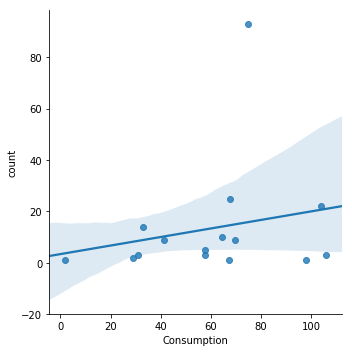

In [61]:
seaborn.lmplot('Consumption', 'count', data=beer_nobel_count, fit_reg=True)